# ASHRAE - Great Energy Prediction III
# This kernel is not finished yet.

### Data
Target Variable
- meter_reading

Categorical Feature - Train & Test Data
- building_id : Foreign key for the building metadata.
- meter : The meter id code. Not every building has all meter types.
    - 0: electrocity
    - 1: chilledwater
    - 2: steam
    - 3: hotwater

Catergorical Feature - Building Meta Data
- site_id: Foreign key for the weather files.
- building_id: Foreign key for 'training.csv'
- primary_use: Indicator of the primary  

Categorical Feature - Weather Train & Test Data
- cloud_corverage
- wind_direction

# Import Module

In [64]:
import numpy as np
import pandas as pd
import stat

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import datetime

import gc

# Load Dataset

In [65]:
building_data = pd.read_csv('../input/ashrae-energy-prediction/building_metadata.csv')
train = pd.read_csv('../input/ashrae-energy-prediction/train.csv')
test = pd.read_csv('../input/ashrae-energy-prediction/test.csv')
weather_train = pd.read_csv('../input/ashrae-energy-prediction/weather_train.csv')
weather_test = pd.read_csv('../input/ashrae-energy-prediction/weather_test.csv')

# Reducing Memory Size

Defined Function

In [66]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [67]:
building_data = reduce_mem_usage(building_data)
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
weather_train = reduce_mem_usage(weather_train)
weather_test = reduce_mem_usage(weather_test)

Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)


# Check Dataset

Defined Function

In [68]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Min'] = df.min().values
    summary['Max'] = df.max().values
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values

    return summary

In [69]:
resumetable(building_data)

Dataset Shape: (1449, 6)


,Name,dtypes,Min,Max,Missing,Uniques
0,site_id,int8,0,15,0,16
1,building_id,int16,0,1448,0,1449
2,primary_use,object,Education,Warehouse/storage,0,16
3,square_feet,int32,283,875000,0,1397
4,year_built,float16,1900,2017,774,116
5,floor_count,float16,1,26,1094,18


In [70]:
print('Primary Using Case:',building_data['primary_use'].unique())

Primary Using Case: ['Education' 'Lodging/residential' 'Office'
 'Entertainment/public assembly' 'Other' 'Retail' 'Parking'
 'Public services' 'Warehouse/storage' 'Food sales and service'
 'Religious worship' 'Healthcare' 'Utility' 'Technology/science'
 'Manufacturing/industrial' 'Services']


- When i checked building meta data, there were a total of 1,449 buildings. The building was mainly used for 16 purposes.
- The area ranged from at least 283 square meters to 875,000 square meters.
- The building's model years varied from 1900 to 2017, but 774 missing values existed.
- The building existed from the first to the 26th floors and 75 percent of the total was missing value.

In [71]:
#resumetable(train)

- The observation period for the training data was from Jan. 1, 2016 to Dec. 31, 2016.

In [72]:
resumetable(weather_train)

Dataset Shape: (139773, 9)


,Name,dtypes,Min,Max,Missing,Uniques
0,site_id,int8,0,15,0,16
1,timestamp,object,2016-01-01 00:00:00,2016-12-31 23:00:00,0,8784
2,air_temperature,float16,-28.9062,47.1875,55,619
3,cloud_coverage,float16,0,9,69173,10
4,dew_temperature,float16,-35,26.0938,113,522
5,precip_depth_1_hr,float16,-1,343,50289,128
6,sea_level_pressure,float16,968,1046,10618,133
7,wind_direction,float16,0,360,6268,43
8,wind_speed,float16,0,19,304,58


- Cloud Coverage are divided into nine classes , but about 50 percent of the total is missing value.
- An observation with precipitation of -1 was present. This is expected to be a sensor error.

# Sectional EDA

## Timestamp Processing

In [73]:
train['date'] = pd.to_datetime(train['timestamp'].str.split(" ", expand = True)[0])

## Target Distribution
### Meter Reading Quantiles
Before show a plot of the target variable, let's look at the Quantile first.

In [74]:
print("Meter Reading (Target Variable) Quantiles:")
print(train['meter_reading'].quantile([0.01, 0.025, 0.1, 0.25, 0.5, 0.75, 0.9, 0.975, 0.99]))

Meter Reading (Target Variable) Quantiles:
0.010       0.000000
0.025       0.000000
0.100       0.325200
0.250      18.299999
0.500      78.775002
0.750     267.984009
0.900     801.997009
0.975    2906.250000
0.990    5449.220215
Name: meter_reading, dtype: float64


### Ploting Meter Reading Values Distribution

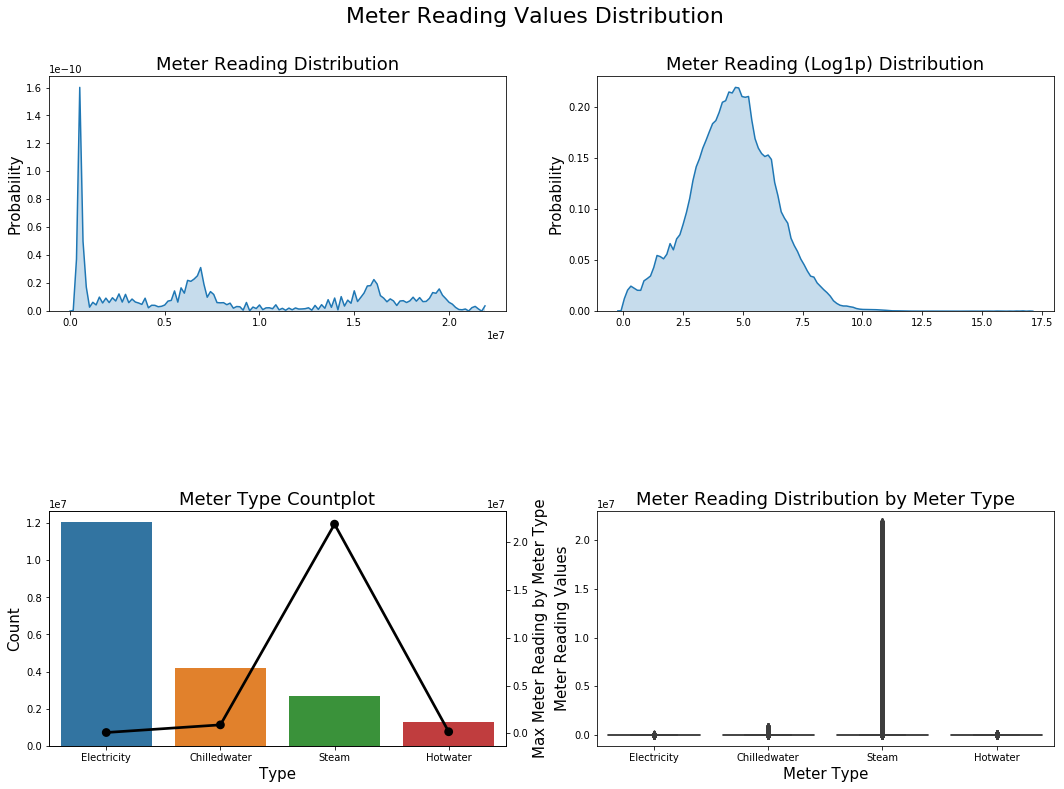

In [75]:
plt.figure(figsize = (18,12))
plt.suptitle('Meter Reading Values Distribution', fontsize = 22)
plt.subplot(221)
sns.distplot(train['meter_reading'], hist = False,kde_kws={"shade": True})
plt.title('Meter Reading Distribution', fontsize = 18)
plt.xlabel("")
plt.ylabel('Probability', fontsize = 15)

plt.subplot(222)
sns.distplot(np.log1p(train['meter_reading']), hist = False,kde_kws={"shade": True})
plt.title('Meter Reading (Log1p) Distribution', fontsize = 18)
plt.xlabel("")
plt.ylabel("Probability",fontsize = 15)

plt.subplot(223)
g = sns.countplot(train['meter'])
plt.xticks(np.arange(4),labels =['Electricity','Chilledwater','Steam','Hotwater'])
g.set_title('Meter Type Countplot', fontsize = 18)
g.set_xlabel('Type', fontsize = 15)
g.set_ylabel('Count', fontsize = 15)

tmp0 = train.loc[train['meter'] == 0]['meter_reading'].max()
tmp1 = train.loc[train['meter'] == 1]['meter_reading'].max()
tmp2 = train.loc[train['meter'] == 2]['meter_reading'].max()
tmp3 = train.loc[train['meter'] == 3]['meter_reading'].max()

tmp_meter = ['Electricity','Chilledwater','Steam','Hotwater']
tmp_meter_reading = [tmp0, tmp1, tmp2, tmp3]

tmp = pd.DataFrame(tmp_meter,tmp_meter_reading)
tmp = tmp.reset_index()
tmp.columns = ['meter','max_meter_reading']

gt = g.twinx()
gt = sns.pointplot(x = 'max_meter_reading', y = 'meter', data = tmp, color = 'black',
                  order = ['Electricity','Chilledwater','Steam','Hotwater'], legend = False)
gt.set_ylabel('Max Meter Reading by Meter Type',fontsize = 15)

plt.subplot(224)
sns.boxplot(x= 'meter', y = 'meter_reading', data = train)
plt.xticks(np.arange(4),labels =['Electricity','Chilledwater','Steam','Hotwater'])
plt.title('Meter Reading Distribution by Meter Type', fontsize = 18)
plt.xlabel('Meter Type', fontsize = 15)
plt.ylabel('Meter Reading Values', fontsize = 15)

plt.subplots_adjust(hspace = 0.85, top = .9)
plt.show()

- The distribution of the target variable shows that about 25% of the total is 0, and the frequency of the value increases after over 0.5 and 1.5.
- If Meter Type is steam type, it can be seen that the target variable is higher than other types.

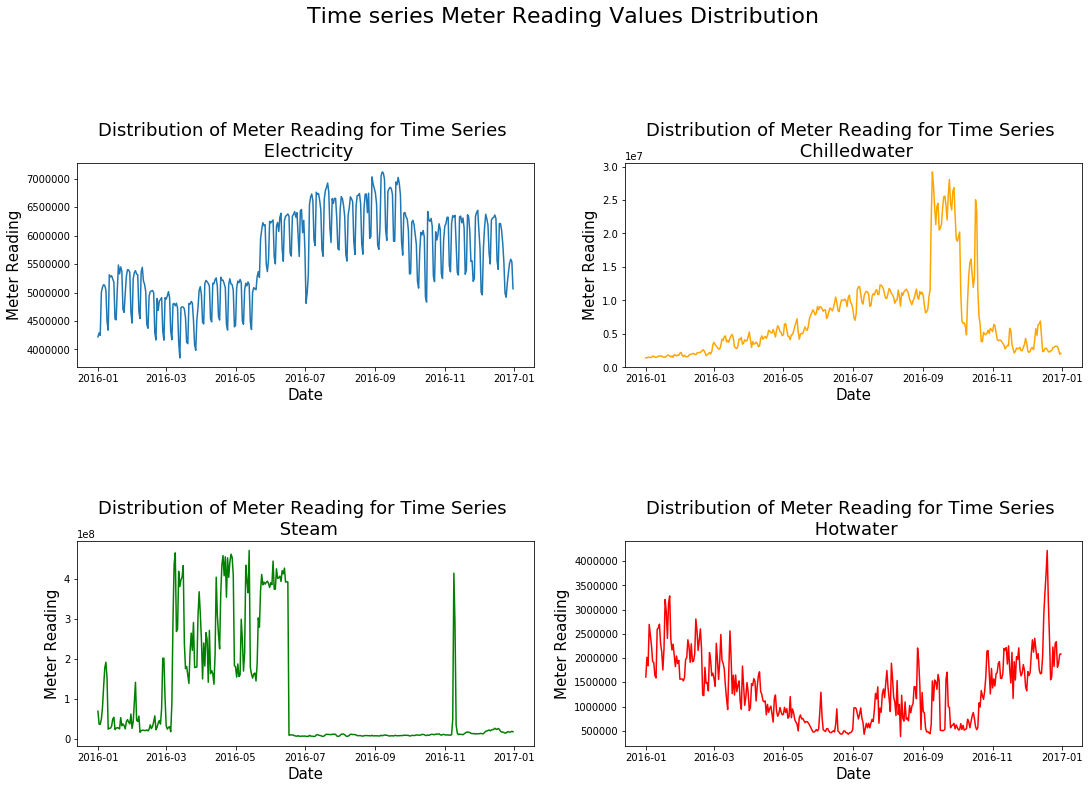

In [76]:
tmp_reading = train.groupby([train['date'].dt.date,'meter'])['meter_reading'].sum().reset_index()

plt.figure(figsize = (18,12))
plt.suptitle('Time series Meter Reading Values Distribution', fontsize = 22)
plt.subplot(221)
sns.lineplot(x = 'date', y = 'meter_reading', data = tmp_reading.loc[tmp_reading['meter'] == 0])
plt.title('Distribution of Meter Reading for Time Series \n Electricity', fontsize = 18)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Meter Reading', fontsize = 15)

plt.subplot(222)
sns.lineplot(x = 'date', y = 'meter_reading', data = tmp_reading.loc[tmp_reading['meter'] == 1], color = 'orange')
plt.title('Distribution of Meter Reading for Time Series \n Chilledwater', fontsize = 18)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Meter Reading', fontsize = 15)

plt.subplot(223)
sns.lineplot(x = 'date', y = 'meter_reading', data = tmp_reading.loc[tmp_reading['meter'] == 2], color = 'green')
plt.title('Distribution of Meter Reading for Time Series \n Steam', fontsize = 18)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Meter Reading', fontsize = 15)

plt.subplot(224)
sns.lineplot(x = 'date', y = 'meter_reading', data = tmp_reading.loc[tmp_reading['meter'] == 3], color = 'red')
plt.title('Distribution of Meter Reading for Time Series \n Hotwater', fontsize = 18)
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Meter Reading', fontsize = 15)

plt.subplots_adjust(hspace = 0.85, top = .8)
plt.show()

- Electricity Meter Reading can be seen to increase significantly after May.
- Childwater meter reading can be seen to increase rapidly since September and become normal after October.
- Steam meter reading has increased by a large margin since March and has shown a normal distribution since June. One thing that stands out is that you can see a sharp increase in November for a short period of time.
- Hotwater meter reading tended to be low in summer and high in winter.

## Building id
The total number of buildings appeared to be 1,449 and we will first check which type of meter there are many.

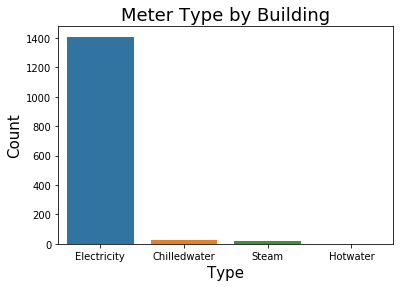

In [77]:
tmp = train.drop_duplicates(['building_id'])[['building_id','meter']]

plt.figure(figsize = (6,4))
g = sns.countplot(tmp['meter'])
plt.xticks(np.arange(4),labels =['Electricity','Chilledwater','Steam','Hotwater'])
g.set_title('Meter Type by Building', fontsize = 18)
g.set_xlabel('Type', fontsize = 15)
g.set_ylabel('Count', fontsize = 15)

plt.show()

- Most meters can be seen using electricity.

# Merging Dataset
- Building_metadata.csv is the data that contains the characteristics of a building. Therefore, the train data and building_data will be combined based on building_id.

## Questions
The merged data will answer the following hypotheses.
- The meter reading will vary depending on the main purpose of use.
- The meter reading will vary depending on the floor area.
- The building year will affect meter reading.
- The number of floors in the building will affect meter reading.
- There will be a difference in meter reading by site.

In [78]:
merged_train = pd.merge(train, building_data, on = 'building_id', how = 'left')
print('Merged Train Data Shape:',merged_train.shape)
merged_train.head()

Merged Train Data Shape: (20216100, 10)


,building_id,meter,timestamp,meter_reading,date,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.0,2016-01-01,0,Education,7432,2008.0,NaN
1,1,0,2016-01-01 00:00:00,0.0,2016-01-01,0,Education,2720,2004.0,NaN
2,2,0,2016-01-01 00:00:00,0.0,2016-01-01,0,Education,5376,1991.0,NaN
3,3,0,2016-01-01 00:00:00,0.0,2016-01-01,0,Education,23685,2002.0,NaN
4,4,0,2016-01-01 00:00:00,0.0,2016-01-01,0,Education,116607,1975.0,NaN


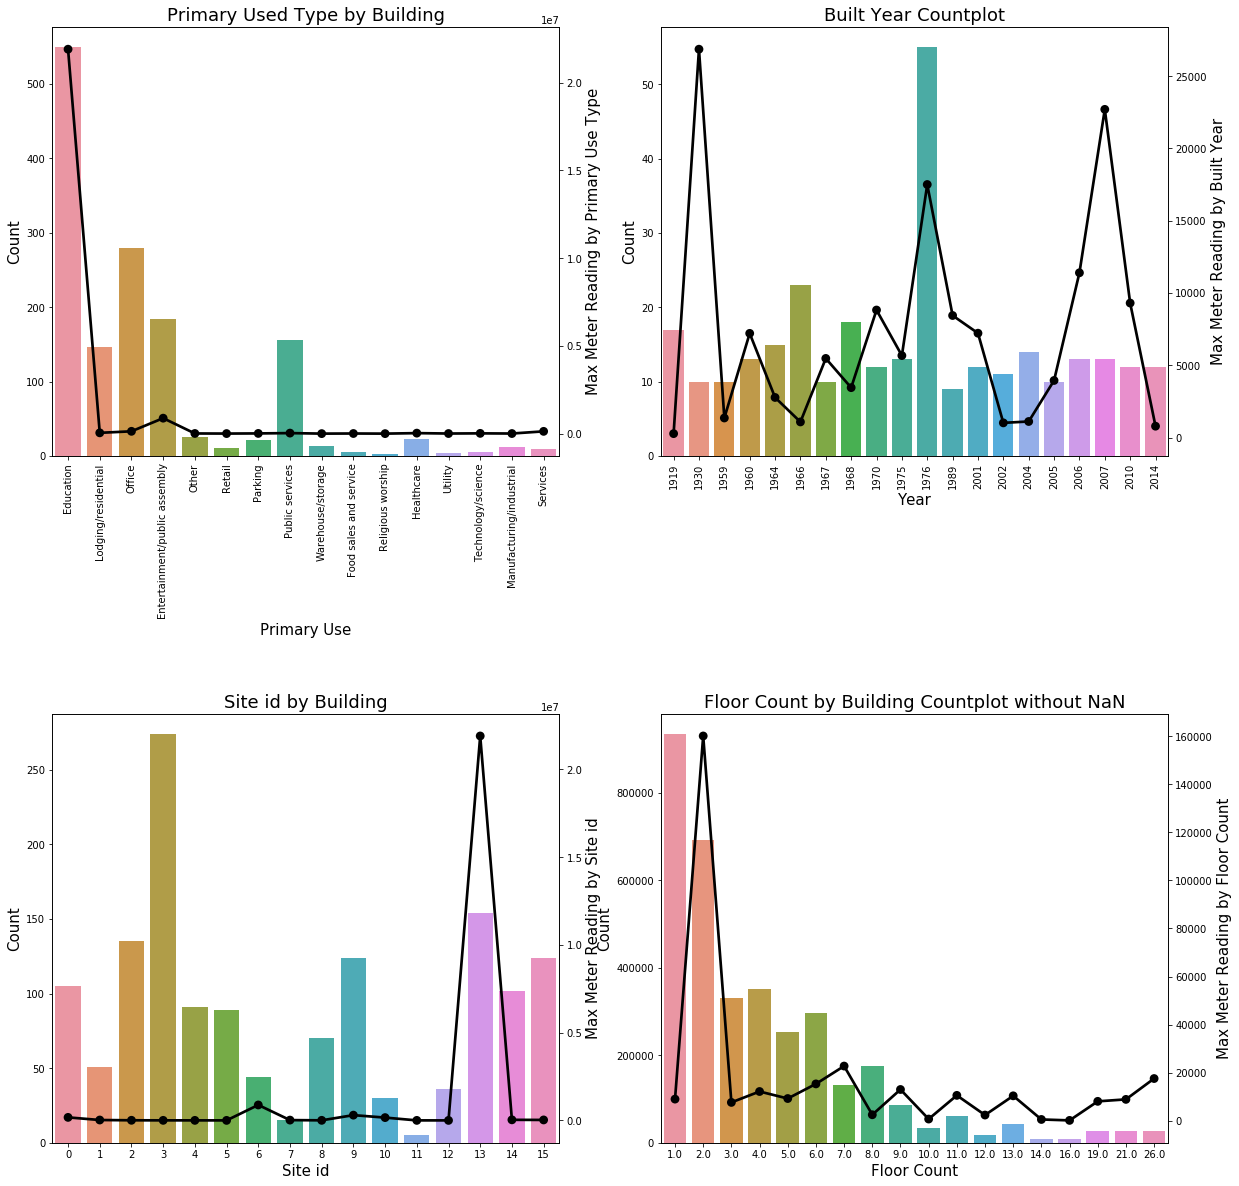

In [79]:
tmp = merged_train.drop_duplicates(['building_id'])[['building_id','primary_use']]

plt.figure(figsize = (20,20))
plt.subplot(221)
g = sns.countplot(x = tmp['primary_use'])
g.set_title('Primary Used Type by Building', fontsize = 18)
g.set_xlabel('Primary Use', fontsize = 15)
g.set_ylabel('Count', fontsize = 15)
g.set_xticklabels(g.get_xticklabels(), rotation = 90)

max_meter_reading = []

for i in merged_train['primary_use'].unique().tolist():
    max_meter_reading.append(merged_train.loc[merged_train['primary_use'] == i]['meter_reading'].max())
    
max_meter_reading

tmp2 = pd.DataFrame(merged_train['primary_use'].unique().tolist(), max_meter_reading)
tmp2 = tmp2.reset_index()
tmp2.columns = ['meter_reading','primary_use']
gt = g.twinx()
gt = sns.pointplot(y = 'meter_reading', x = 'primary_use', data = tmp2, color = 'black',
                  order = merged_train['primary_use'].unique().tolist(), legend = False)
gt.set_ylabel('Max Meter Reading by Primary Use Type',fontsize = 15)
gt.set_xticklabels(gt.get_xticklabels(), rotation = 90)

plt.subplot(222)

tmp = merged_train.drop_duplicates(['building_id'])[['building_id','year_built']]
tmp = tmp.groupby(['year_built'])['building_id'].count()
tmp = pd.DataFrame(tmp).reset_index()
tmp.columns = ['year_built','count']
tmp['year_built'] = tmp['year_built'].astype(int)
tmp = tmp.sort_values(by = 'count', ascending= False)
tmp_top20 = tmp.head(20)

g = sns.barplot(x = tmp_top20['year_built'], y = tmp_top20['count'])
g.set_title('Built Year Countplot', fontsize = 18)
g.set_xlabel('Year', fontsize = 15)
g.set_ylabel('Count', fontsize = 15)
g.set_xticklabels(g.get_xticklabels(), rotation = 90)

max_meter_reading = []

for i in tmp_top20['year_built']:
    max_meter_reading.append(merged_train.loc[merged_train['year_built'] == i]['meter_reading'].max())

tmp_top20['max_meter_reading'] = max_meter_reading

gt = g.twinx()
gt = sns.pointplot(y= 'max_meter_reading', x = 'year_built', data = tmp_top20, color = 'black', legend = False)
gt.set_xlabel('Year',fontsize = 15)
gt.set_ylabel('Max Meter Reading by Built Year', fontsize = 15)
gt.set_xticklabels(gt.get_xticklabels(), rotation = 90)

plt.subplot(223)
tmp = merged_train.drop_duplicates(['building_id'])[['building_id','site_id']]
g = sns.countplot(x = tmp['site_id'])
g.set_title('Site id by Building', fontsize = 18)
g.set_ylabel('Count', fontsize = 15)
g.set_xlabel('Site id', fontsize = 15)

max_meter_reading = []

for i in merged_train['site_id'].unique().tolist():
    max_meter_reading.append(merged_train.loc[merged_train['site_id'] == i]['meter_reading'].max())

tmp3 = pd.DataFrame(merged_train['site_id'].unique().tolist(), max_meter_reading)
tmp3 = tmp3.reset_index()
tmp3.columns = ['max_meter_reading','site_id']
gt = g.twinx()
gt = sns.pointplot(y = 'max_meter_reading', x = 'site_id', data = tmp3, color = 'black',
                  order = merged_train['site_id'].unique().tolist(), legend = False)
gt.set_ylabel('Max Meter Reading by Site id',fontsize = 15)

plt.subplot(224)
tmp = np.sort(merged_train['floor_count'].unique())
tmp2 = []
for i in tmp:
    tmp2.append(merged_train.loc[merged_train['floor_count'] == i]['meter_reading'].max())

g = sns.countplot(merged_train['floor_count'])
g.set_title('Floor Count by Building Countplot without NaN', fontsize = 18)
g.set_xlabel('Floor Count', fontsize = 15)
g.set_ylabel('Count', fontsize = 15)

gt = g.twinx()
gt = sns.pointplot(x = tmp, y = tmp2, color = 'black')
gt.set_ylabel('Max Meter Reading by Floor Count', fontsize = 15)

plt.subplots_adjust(hspace = .6, top = .9)
plt.show()

- The main use of buildings can be seen as the largest number of educational buildings. It can also be seen that the maximum value of the target variable is included here.
- It can be seen that the maximum meter_reading of buildings used outside of educational purposes is almost similar.
- This is a visualization of the top 20 years when the most buildings were built except NaN. Except for NaN, the largest number of buildings were built in 1976.
- It can be seen that in 1930 there is a relatively high maximum meter_reading. It can be seen that 2017 and 1976 are the next highest.
- Observations with maximum meter reading occurred in site 13.
- In particular, the maximum meter reading of the two floor building was the highest.

# Weather Data
We will check the weather data by referring to the [ASHRAE - Missing Weather Data Handling](https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling) Notebook.

In [89]:
weather_train = pd.read_csv('../input/ashrae-energy-prediction/weather_train.csv')

In [90]:
print("Weather Train Dataset Shape:", weather_train.shape)
weather_train.head()

Weather Train Dataset Shape: (139773, 9)


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


## Check Missing Values
First, let's define a function to check missing values.

In [91]:
def missing_statistics(df):
    statistics = pd.DataFrame(df.isnull().sum()).reset_index()
    statistics.columns = ['Column Name','Missing Values']
    statistics['Total Rows'] = df.shape[0]
    statistics['% Missing'] = round((statistics['Missing Values']/statistics['Total Rows'])*100,2)
    return statistics

## Missing Hours
The csv file is the data for the hourly weather in 16 sites in 2016.Therefore, there must be 140,544 rows. However, there are only 139,773 rows in a given file. 771 hours is missing.

In [ ]:
time_format = "%Y-%m-%d %H:%M:%S"

start_date = datetime.datetime.strptime(weather_train['timestamp'].min(), time_format)
end_date = datetime.datetime.strptime(weather_train['timestamp'].max(), time_format)
total_hours = int(((end_date - start_date).total_seconds() + 3600)/ 3600)
hour_list = [(end_date - datetime.timedelta(hours = x)).strftime(time_format) for x in range(total_hours)]
print(hour_list[:3])

missing_hours = []
for site_id in np.sort(merged_train['site_id'].unique()):
    site_hours = np.array(weather_train.loc[weather_train['site_id'] == site_id]['timestamp'])
    new_rows = pd.DataFrame(np.setdiff1d(hour_list,site_hours), columns = ['timestamp'])
    new_rows['site_id'] = site_id
    weather_train = pd.concat([weather_train,new_rows])

['2016-12-31 23:00:00', '2016-12-31 22:00:00', '2016-12-31 21:00:00']


### Count Missing Values

In [ ]:
missing_statistics(weather_train)

## Day,Week & Month Columns

In [ ]:
weather_train['datetime'] = pd.to_datetime(weather_train['timestamp'])
weather_train['day'] = weather_train['datetime'].dt.day
weather_train['week'] = weather_train['datetime'].dt.week
weather_train['month'] = weather_train['datetime'].dt.month

In [ ]:
weather_train.head()

## Reset Index for Fast Update

In [ ]:
weather_train = weather_train.set_index(['site_id','day','month'])

### Fill Air Temperature
Missing values for temperature will be filled with <b>daily average temperatures of the month</b>. Because the temperature varies greatly from season to season, it is not good to use the average annual temperature.

### Fill Cloud Coverage
Almost 50% data is missing. In addition, values are continuously missing. So, calculate daily average cloud coverage of the month and fill rest missing values with last valid observation.

In [ ]:
# Calculate daily average cloud coverage of the month
cloud_coverage_filler = weather_train.groupby(['site_id','day','month'])['cloud_coverage'].mean()
# Fill rest missing values with last valid observation
cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

weather_train.update(cloud_coverage_filler, overwrite = False)

### Fill Dew Temperature

In [ ]:
dew_temperature_filler = pd.DataFrame(weather_train.groupby(['site_id','day','month'])['dew_temperature'].mean(), columns = ['dew_temperature'])
weather_train.update(dew_temperature_filler, overwrite = False)

### Fill Sea level Pressure

In [ ]:
# Calculate daily average Sea level Pressure of the month
sea_level_filler = weather_train.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
# Fill rest missing values with last valid observation
sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method = 'ffill'), columns = ['sea_level_pressure'])

weather_train.update(sea_level_filler, overwrite = False)

### Fill Wind Speed

In [ ]:
wind_speed_filler = pd.DataFrame(weather_train.groupby(['site_id','day','month'])['wind_speed'].mean(), columns = ['wind_speed'])
weather_train.update(wind_speed_filler, overwrite = False)

### Fill precip_depth_1_hr
This value indicates very little rain and how much snow it has fallen. This value is greater than zero, but it will not be able to be measured with a rain gauge.

In [ ]:
# Calculate daily average Precipitation Depth 1 hour of the month
precip_depth_filler = weather_train.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
# Fill rest missing values with last valid observation
precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method = 'ffill'), columns = ['precip_depth_1_hr'])

weather_train.update(precip_depth_filler, overwrite = False)

### Remove Useless Feature

In [ ]:
weather_train = weather_train.reset_index()
weather_train.drop(columns = ['datetime','day','week','month'], inplace = True)